# Generic cancer network analysis effective graph

> Based on **PNAS ER+ Breast Cancer notebook** from A.J. Gates, R.B. Correia, X. Wang, & L.M. Rocha [2021]. "The effective graph reveals redundancy, canalization, and control pathways in biochemical regulation and signaling". Proceedings of the National Academy of Sciences (PNAS), 118 (12).

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import graphviz
from copy import copy
import os
# Cana
import cana
from cana.boolean_network import BooleanNetwork
from cana.datasets.bio import BREAST_CANCER, LEUKEMIA
# from cana.datasets.regan_networks import pi3kcellcycleapoptosis
from cana.drawing.canalizing_map import draw_canalizing_map_graphviz
# from cana.custom_modules import visualize_schemata
# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.text import Text
from matplotlib.patches import Circle, Rectangle, RegularPolygon
from matplotlib.collections import PatchCollection
# Networkx
import networkx as nx



In [2]:
def calculates_path_length(G, path, weight='weight'):
    path_weight_sum = 0.0
    weakest_link = np.inf
    for source, target in zip(path[:-1], path[1:]):
        edge_weight = G.edges[(source, target)][weight]
        path_weight_sum += edge_weight
        if edge_weight < weakest_link:
            weakest_link = edge_weight
    return path_weight_sum, weakest_link

# Load network of interest and calculate reduncy measures

In [3]:
# C = BREAST_CANCER()
C = LEUKEMIA()
# regan_models = []
# regan_models = load_all_regan_pi3k_models()
# for N in regan_models:
#     print(N.name)

# PI3K_full = pi3kcellcycleapoptosis()
# print(PI3K_full.name)
# C = PI3K_full

**Calculate redundancy measures at the node level - input redundancy, effective connectivity, and input symmetry**

In [4]:
pd.set_option('display.max_rows', 500)
pd.options.display.float_format = '{:.2g}'.format

node_analysis_df = pd.DataFrame({
        'node':[n.name for n in C.nodes],
        'k':[n.k for n in C.nodes],
        'k_r':[n.input_redundancy(norm=False) for n in C.nodes],
        'k_e':[n.effective_connectivity(norm=False) for n in C.nodes],
        'k_r*':[n.input_redundancy(norm=True) for n in C.nodes],
        'k_e*':[n.effective_connectivity(norm=True) for n in C.nodes],
        'k_s*':[n.input_symmetry(norm=True) for n in C.nodes],
    })
#df = df[['k','k_r','k_e','k_r*','k_e*','k^{out}','k_e^{out}']]
node_analysis_df.sort_values('k_r*',ascending=False,inplace=True)
display(node_analysis_df)
#print(df.to_latex(escape=False))
#
drugs = [3, 4, 5, 6, 7, 8, 9]
dfd = node_analysis_df.loc[drugs, ['node', 'k_r*', 'k_e*', 'k_s*']]
dfd = node_analysis_df.loc[:, ['node', 'k_r*', 'k_e*', 'k_s*']]

# display(dfd)

,node,k,k_r,k_e,k_r*,k_e*,k_s*
48,MCL1,5,3.9,1.1,0.78,0.23,0.64
30,IFNG,6,4.6,1.4,0.76,0.24,0.45
22,JAK,6,4.4,1.6,0.74,0.26,0.3
47,BclxL,5,3.6,1.4,0.72,0.28,0.56
36,FasL,4,2.8,1.2,0.7,0.3,1
14,NFKB,5,3.4,1.6,0.68,0.32,0.27
10,GAP,5,3.4,1.6,0.68,0.32,0.33
42,Caspase,5,3.2,1.8,0.65,0.35,0.54
41,DISC,5,3.2,1.8,0.64,0.36,0.59
45,BID,4,2.5,1.5,0.62,0.38,0.45


**Replace canalization values of input nodes with 'NaN' to exclude them from summary node statistics**

In [9]:
# node_analysis_df = node_analysis_df.loc[node_analysis_df['k'] == 1, ['k_r', 'k_e', 'k_r*', 'k_e*', 'k_s*']] = 'NaN', 'NaN', 'NaN', 'NaN', 'NaN'
print(type(node_analysis_df))

node_analysis_df.loc[(node_analysis_df.k==1),'k_r'] = np.nan
node_analysis_df.loc[(node_analysis_df.k==1),'k_e'] = np.nan
node_analysis_df.loc[(node_analysis_df.k==1),'k_r*'] = np.nan
node_analysis_df.loc[(node_analysis_df.k==1),'k_e*'] = np.nan
node_analysis_df.loc[(node_analysis_df.k==1),'k_s*'] = np.nan
display(node_analysis_df)

# If there is an output node with only one input, this will replace those values also and the 0
# for the redundancy measures also won't get put in the averages!!!!!!!!!!!! How can I tell if it is 
# an output node versus an input node with only degree 1??????

# type(node_analysis_df.loc[0,'k_s*'])

<class 'pandas.core.frame.DataFrame'>


,node,k,k_r,k_e,k_r*,k_e*,k_s*
48,MCL1,5,3.9,1.1,0.78,0.23,0.64
30,IFNG,6,4.6,1.4,0.76,0.24,0.45
22,JAK,6,4.4,1.6,0.74,0.26,0.3
47,BclxL,5,3.6,1.4,0.72,0.28,0.56
36,FasL,4,2.8,1.2,0.7,0.3,1
14,NFKB,5,3.4,1.6,0.68,0.32,0.27
10,GAP,5,3.4,1.6,0.68,0.32,0.33
42,Caspase,5,3.2,1.8,0.65,0.35,0.54
41,DISC,5,3.2,1.8,0.64,0.36,0.59
45,BID,4,2.5,1.5,0.62,0.38,0.45


**Summary statistics at the node level for canalization values of interest**

In [ ]:
#summary stats

display(node_analysis_df.describe())
# node_analysis_df[node_analysis_df != -1].mean() # Update - works if you replace values with -1 instead. Or anything that isn't used in the calculations.
                                                # very very close - but some of the symetry values really are 0. 
                                               # I should probably actaully exclude them, but this is a really good start
    

In [ ]:
# for n,v in C.out_degree():
#     print(n, v)

#  I should be able to get that from the regular graphs as well?? It must not be in the Boolean networks?

# Effective graph(s) for network of interest

Make the various graphs of interest

In [3]:
SG = C.structural_graph()
EG = C.effective_graph(threshold=-1) # now ... what is the difference .... I have my intuition but could be very wrong. And what does -1 mean???
#
EG0 = C.effective_graph(threshold=0)
EG0p2 = C.effective_graph(threshold=.2)
EG0p4 = C.effective_graph(threshold=.4)
EG0p6 = C.effective_graph(threshold=.6)
EG0p8 = C.effective_graph(threshold=.8)

Similar to previous section, but includes the effectiveness of the outgoing edges - as coming from the EG.


In [ ]:
pd.options.display.float_format = '{:.2g}'.format
pd.set_option('display.max_rows', 500)
#
df = pd.DataFrame({
        'node':[n.name for n in C.nodes],
        'k':[n.k for n in C.nodes],
        'k_r':[n.input_redundancy(norm=False) for n in C.nodes],
        'k_e':[n.effective_connectivity(norm=False) for n in C.nodes],
        'k_r*':[n.input_redundancy(norm=True) for n in C.nodes],
        'k_e*':[n.effective_connectivity(norm=True) for n in C.nodes],
        'k_s*':[n.input_symmetry(norm=True) for n in C.nodes],
        'k^{out}':[v for n,v in EG.out_degree()],
        'k_e^{out}':[v for n,v in EG.out_degree(weight='weight')],
    })
#df = df[['k','k_r','k_e','k_r*','k_e*','k^{out}','k_e^{out}']]
df['k_e^{out}/k^{out}'] = df['k_e^{out}'] / df['k^{out}']
df.sort_values('k',ascending=False,inplace=True)
#print(df.to_latex(escape=False))
#
drugs = [3, 4, 5, 6, 7, 8, 9]
dfd = df.loc[drugs, ['node', 'k_r*', 'k_e*', 'k_s*', 'k^{out}', 'k_e^{out}', 'k_e^{out}/k^{out}']]
dfd = df.loc[:, ['node', 'k^{out}', 'k_e^{out}', 'k_e^{out}/k^{out}']]
dfd.sort_values(['k^{out}', 'k_e^{out}'], ascending=[False, False], inplace=True)
display(dfd)
display(dfd.describe())

## Additional analysis of the different effective graphs: self-loops, strong and weakly connected , finally redundancy

In [ ]:
def number_of_input_nodes(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if inputs == [] or inputs == [True]:
            count += 1
    return count
#
def number_of_nodes_with_self_loop(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if any(inputs):
            count += 1
    return count
#
def number_of_input_nodes_with_self_loop(G):
    count = 0
    for n, d in G.nodes(data=True):
        inputs = [True if i == j else False for i, j in G.in_edges(n)]
        if inputs == [True]:
            count += 1
    return count

In [ ]:
for G, graph in [(SG, 'IG'), (EG0, 'EG'), (EG0p2, 'EG (0.2)'), (EG0p4, 'EG (0.4)'), (EG0p6, 'EG (0.6)'), (EG0p8, 'EG (0.8)')]:
    n_nodes = G.number_of_nodes()
    print('{g:s}: Number of nodes: {n:d}'.format(g=graph, n=n_nodes))
    n_nodes_with_self_loop = number_of_nodes_with_self_loop(G)
    print('{g:s}: Number nodes with a self-loop: {n:d}'.format(g=graph, n=n_nodes_with_self_loop))
    n_input_nodes = number_of_input_nodes(G)
    print('{g:s}: Number of input nodes: {n:d}'.format(g=graph, n=n_input_nodes))
    n_input_nodes_with_self_loop = number_of_input_nodes_with_self_loop(G)
    print('{g:s}: Number of input nodes with self-loop: {n:d}'.format(g=graph, n=n_input_nodes_with_self_loop))
    print('--')

In [ ]:
def weakly_connected_components(G):
    wcc = [len(cc) for cc in nx.weakly_connected_components(G)]
    return len(wcc), wcc
#
def strongly_connected_components(G):
    scc = [len(cc) for cc in nx.strongly_connected_components(G)]
    return len(scc), scc
#
def SortedCounter(l):
    c = dict(sorted(Counter(l).most_common(), reverse=True)) 
    return c

In [ ]:
for G, graph in [(SG, 'IG'), (EG0, 'EG'), (EG0p2, 'EG (0.2)'), (EG0p4, 'EG (0.4)'), (EG0p6, 'EG (0.6)'), (EG0p8, 'EG (0.8)')]:
    n_wcc, wcc = weakly_connected_components(G)
    print('{g:s}: {n:d} weakly connected components, sizes {l:}'.format(g=graph, n=n_wcc, l=SortedCounter(wcc)))
    #
    n_scc, scc = strongly_connected_components(G)
    print('{g:s}: {n:d} strongly connected components, sizes {l:}'.format(g=graph, n=n_scc, l=SortedCounter(scc)))
    print('--')

In [ ]:
wcc = nx.weakly_connected_components(EG0p2)
for id,comp in enumerate(wcc):
    print('Component id={id:d} with size: {size:d}'.format(id=id, size=len(comp)))
    names = []
    for node in comp:
        name = G.nodes[node]['label']
        names.append(name)
    print(names)

In [ ]:
net_redundancy = 0
#
for nid, node in enumerate(C.nodes,start=0):
    net_redundancy += node.input_redundancy(norm=False)
#
net_redundancy_norm = net_redundancy / C.Nnodes
#
print("Total Network Redundancy: {:.4} (norm: {:.4})".format(net_redundancy, net_redundancy_norm))

## Graph(s) vizualization 

In [ ]:
# Print node names
for i,d in SG.nodes(data=True):
    print(i,d)

In [ ]:
dict_effconn = {nid: node.effective_connectivity(norm=False) 
    for nid, node in enumerate(C.nodes, start=0) }
#
nx.set_node_attributes(EG, dict_effconn, 'effective_connectivity')

In [ ]:
# # Node Manual Positioning - RUN ONLY FOR ER+ Network!!!!!
idmap = {d['label']:i for i,d in SG.nodes(data=True)}
att = {}


### Interaction Graph

In [ ]:
pSG = graphviz.Digraph(name='Structural Graph', engine='neato')
pSG.attr('graph', size='10,10', concentrate='false', simplify='false', overlap='false',splines='true',ratio='.7',outputorder="edgesfirst",nodesep='.25',mindist='.20')
pSG.attr('node', pin='true', shape='box', height='0.4', fixedsize='false',margin='.05', color='black', penwidth='1', fontname='Helvetica', fontcolor='black',fontsize='10' ) # style='filled', fillcolor='#515660',)
pSG.attr('edge', arrowhead='normal', arrowsize='.5', penwidth='2.5')

# for nid,SGatt in SG.nodes(data=True):
#     label = SGatt['label']
#     if nid in att:
#         pos = att[nid].get('pos', '')
#         shape = att[nid].get('shape', 'box')
#         fillcolor = colors[att[nid].get('type')]
#         #width = ''att[nid].get('width', '0.7')
#         pSG.node(str(nid), label=label, pos=pos, shape=shape, fillcolor=fillcolor, )
        
for nid,d in SG.nodes(data=True):
    label = d['label']
#     ntype = att[nid].get('type')
#     pos = att[nid].get('pos', '')
#     shape = att[nid].get('shape')
#     fillcolor = colors[ntype]
    pSG.node(str(nid), label=label, ) #pos=pos, shape=shape, fillcolor=fillcolor,)

max_penwidth = 4
for uid,vid,d in SG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    # self loop color
    if uid == vid:
        color = '#bdbdbd'
        uid = uid + ':w'
        vid = vid + ':c'
    else:
        color = '#636363'
    pSG.edge(uid, vid, weight=weight, color=color)
    
display(pSG)
pSG.format ='svg'
# Export
pSG.render("generic_graph", cleanup=True) 
pSG.render('generic_graph.gv')

# could obviously extract the network name ... could also
# extract positinos here and force the rest of the graphs to be this look. - that is what I want to do ...

## Effective Graph

In [ ]:
pEG = graphviz.Digraph(name='Structural Graph', engine='neato')
pEG.attr('graph', size='10,10', concentrate='false', simplify='false', overlap='false',splines='true',ratio='.7',outputorder="edgesfirst",nodesep='.25',mindist='.20')
pEG.attr('node', pin='true', shape='box', height='0.4', fixedsize='false',margin='.05', color='black', penwidth='1', fontname='Helvetica', fontcolor='black',fontsize='10' ) # style='filled', fillcolor='#515660',)
pEG.attr('edge', arrowhead='normal', arrowsize='.5', penwidth='2.5')

max_effoutdegree = max([v for n,v in EG.out_degree()])
list_effconn = [d['effective_connectivity'] for n,d in EG.nodes(data=True)]
min_effconn, max_effconn = min(list_effconn), max(list_effconn)

for nid,d in EG.nodes(data=True):
    label = d['label']
#     ntype = att[nid].get('type')
#     pos = att[nid].get('pos', '')
#     shape = att[nid].get('shape')
#     fillcolor = colors[ntype]
    pEG.node(str(nid), label=label, ) #pos=pos, shape=shape, fillcolor=fillcolor,)

max_penwidth = 4
for uid,vid,d in EG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight']*max_penwidth )
    if d['weight'] > 0:       
        if uid == vid:
            color = '#bdbdbd'
            uid = uid + ':w'
            vid = vid + ':c'
        else:
            color = '#636363'
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth, color=color)
    else:
        pEG.edge(uid,vid, style='dashed', color='#A90533')
    
display(pEG)
# Export
pEG.format ='svg'
pEG.render("generic-EG", cleanup=True)

In [ ]:
pEG = graphviz.Digraph(name='Structural Graph', engine='neato')
pEG.attr('graph', size='10,10', concentrate='false', simplify='false', overlap='false',splines='true',ratio='.7',outputorder="edgesfirst",nodesep='.25',mindist='.20')
pEG.attr('node', pin='true', shape='box', height='0.4', fixedsize='false',margin='.05', color='black', penwidth='1', fontname='Helvetica', fontcolor='black',fontsize='10' ) # style='filled', fillcolor='#515660',)
pEG.attr('edge', arrowhead='normal', arrowsize='.5', penwidth='2.5')

max_effoutdegree = max([v for n,v in EG0p2.out_degree()]) # not sure why the maxeffoutdegree is coming from the 0.20 graph - doesn't seem to make a difference in the graphical output
list_effconn = [d['effective_connectivity'] for n,d in EG.nodes(data=True)]
min_effconn, max_effconn = min(list_effconn), max(list_effconn)

# Manually position nodes using the DotLayout
# dotpos = nx.drawing.nx_agraph.graphviz_layout(EG, prog='dot', args='-Gconcentrate=false -Gsimplify=false -Goverlap=false -Gsplines=True -Gratio=compress -Goutputorder=edgesfirst -Gnodesep=.25 -Granksep=.20')
#
for nid,d in EG.nodes(data=True):
    label = d['label']
#     ntype = att[nid].get('type')
#     x,y = dotpos[nid][0], dotpos[nid][1]
#     pos = '{x:.2f},{y:.2f}'.format(x=x, y=y) #''#att[nid].get('pos', '')
#     shape = att[nid].get('shape')
#     fillcolor = colors[ntype]
    pEG.node(str(nid), label=label) #, pos=pos)# put postions here!!!


# for nid,d in EG0p4.nodes(data=True):
#     label = d['label']
#     ntype = att[nid].get('type')
#     pos = att[nid].get('pos', '')
#     shape = att[nid].get('shape')
#     fillcolor = colors[ntype]
#     pEG.node(str(nid), label=label, pos=pos, shape=shape, fillcolor=fillcolor,)

max_penwidth = 4
for uid,vid,d in EG0p4.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight']*max_penwidth )
    if d['weight'] > 0.4:       
        if uid == vid:
            color = '#bdbdbd'
            uid = uid + ':w'
            vid = vid + ':c'
        else:
            color = '#636363'
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth, color=color)
    else:
        pEG.edge(uid,vid, style='dashed', color='#A90533')

# NOTE: without per specifying node positions, because the thresholded effective graphs can disconnect the graph
# expect a very different layout compared to the previous graph displays
        
display(pEG)
# Export
pEG.format ='svg'
pEG.render("generic-EGt0p4", cleanup=True)

In [ ]:
pEG = graphviz.Digraph(name='Structural Graph', engine='dot')
pEG.attr('graph', size='8.5,9', concentrate='false', simplify='false', overlap='false',splines='true',ratio='compress',outputorder="edgesfirst",nodesep='.25',ranksep='.25')
pEG.attr('node', pin='true', shape='box', height='0.4', fixedsize='false',margin='.05', color='black', penwidth='1', fontname='Helvetica', fontcolor='black',fontsize='10' ) # style='filled', fillcolor='#515660',)
pEG.attr('edge', arrowhead='normal', arrowsize='.5', color='black', penwidth='3')

max_effoutdegree = max([v for n,v in EG.out_degree()])
list_effconn = [d['effective_connectivity'] for n,d in EG.nodes(data=True)]
min_effconn, max_effconn = min(list_effconn), max(list_effconn)
#
# ColorBar
interval = np.linspace(0.0, 0.70, 256)
cmap = LinearSegmentedColormap.from_list('custom', ['white','#d62728'])
#norm = mpl.colors.Normalize(vmin=0, vmax=1)
norm = mpl.colors.Normalize(vmin=1, vmax=max_effoutdegree)
#
colornodes = ['Apoptosis', 'Apoptosis_2', 'Apoptosis_3', 'Proliferation', 'Proliferation_2', 'Proliferation_3', 'Proliferation_4']
#
# Manually position nodes using the DotLayout
dotpos = nx.drawing.nx_agraph.graphviz_layout(EG, prog='dot', args='-Gconcentrate=false -Gsimplify=false -Goverlap=false -Gsplines=True -Gratio=compress -Goutputorder=edgesfirst -Gnodesep=.25 -Granksep=.20')
#
for nid,d in EG.nodes(data=True):
    label = d['label']
#     ntype = att[nid].get('type')
    x,y = dotpos[nid][0], dotpos[nid][1]
#     pos = '{x:.2f},{y:.2f}'.format(x=x, y=y) #''#att[nid].get('pos', '')
#     shape = att[nid].get('shape')
#     fillcolor = colors[ntype]
    pEG.node(str(nid), label=label)

max_penwidth = 4
for uid,vid,d in EG.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight']*max_penwidth )
    if d['weight'] >= 0.2:
        if uid == vid:
            color = '#bdbdbd'
            uid = uid + ':w'
            vid = vid + ':c'
        else:
            color = '#636363'
        pEG.edge(uid,vid, weight=weight, penwidth=penwidth, color=color)
    else:
        pass
        #pEG.edge(uid,vid, style='dashed', color='#A90533')
 
# Export
display(pEG)
pEG.format ='svg'
pEG.render("generic-EGt0p2-dotlayout", cleanup=True)

In [ ]:
# Legend - only makes sense for breast cancer network
# from matplotlib.patches import Patch

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2,2))

# labels = [
#     'RTK signaling',
#     'PI3K pathway',
#     'MAPK pathway',
#     'AKT pathway',
#     'mTORC1 pathway',
#     'ER signaling',
#     'Apoptosis',
#     'Proliferation',
#     'Drugs']

# handles = []
# for label in labels:
#     facecolor = colors[label]
#     patch = Patch(facecolor=facecolor, edgecolor='black', label=label)
#     handles.append(patch)

# leg = ax.legend(handles=handles, labels=labels, loc='upper left', ncol=3)
# plt.axis('off')

# plt.show()

## Dynamic Canalization analysis

### Generic dynamics canalizaiton map (DCM) for network

In [ ]:
# Request the DCM to the Network
DCM = C.dynamics_canalization_map(simplify=True)

In [ ]:
def draw_canalizing_map_graphviz_custom(DG=None,
                                 on_node_fillcolor='black', on_node_fontcolor='white',
                                 off_node_fillcolor='white', off_node_fontcolor='black',

                                 input_node_bordercolor='gray',
                                 output_node_bordercolor='red',
                                 controlled_node_bordercolor='green',
                                 constant_node_bordercolor='pink',

                                 literal_edge_color='#208120', output_edge_color='#812020',
                                 fusing_edge_color='#a5a5cc', fused_edge_color='#202081',
                                 simplified_edge_color='#cca37a',

                                 fusing_edge_arrowhead='none',
                                 fused_edge_arrowhead='dot',
                                 literal_edge_arrowhead='dot',
                                 out_edge_arrowhead='normal',

                                 simplified_edge_arrowhead='normal',
                                 *args, **kwargs):
    """ Draws the Canalizing Map (CM) using the GraphViz plotting engine.

    Args:
        DG (networkx.DiGraph) : The node Canalizing Map (CM).

    Returns:
        (graphviz) : The network in graphviz dot format.
    """
    G = graphviz.Digraph(engine='dot')
    G.attr('graph', size='9,9', concentrate='false', simplify='false', overlap='false',splines='true',ratio='compress',outputorder="edgesfirst",nodesep='.25',ranksep='.25')
#     G.graph_attr.update(overlap='false')
    G.node_attr.update(fontname='helvetica', shape='box', fontcolor='black', fontsize='12', width='.4', fixedsize='false', style='filled', color='gray', penwidth='3')
    G.edge_attr.update(arrowhead='dot', color='gray', arrowsize='1')

    # Nodes
    for n, d in DG.nodes(data=True):
        if 'type' not in d:
            raise AttributeError("Node type could not be found. Must be either 'variable', 'threshold' or 'fusion'.")

        # Variable Nodes
        if d['type'] == 'variable':

            if 'mode' in d:
                # Border Color. Dependents if 'input', 'output', 'controlled' or 'constant'
                if d['mode'] == 'input':
                    mode_bordercolor = input_node_bordercolor
                elif d['mode'] == 'output':
                    mode_bordercolor = output_node_bordercolor
                elif d['mode'] == 'constant':
                    mode_bordercolor = constant_node_bordercolor
                elif d['mode'] == 'controled':
                    mode_bordercolor = controlled_node_bordercolor
            else:
                mode_bordercolor = output_node_bordercolor

            if d['value'] == 0:
                label = d.get('label', d.get('label-tmp', 'None'))
                G.node(name=n, label=label, fontcolor=off_node_fontcolor, fillcolor=off_node_fillcolor, color=mode_bordercolor)
            elif d['value'] == 1:
                label = d.get('label', d.get('label-tmp', 'None'))
                G.node(name=n, label=label, fontcolor=on_node_fontcolor, fillcolor=on_node_fillcolor, color=mode_bordercolor)

        # Threshold Nodes
        elif d['type'] == 'threshold':
            G.node(name=n, label=d['label'], shape='diamond', style='filled,solid', fillcolor='#dae8f4', fontcolor='black', color='#b5d1e9', width='.4', height='.4')

        elif d['type'] == 'fusion':
            G.node(name=n, label='', shape='none', width='0', height='0', margin='0')

    # Edges
    for s, t, d in DG.edges(data=True):
        color = literal_edge_color
        arrowhead = out_edge_arrowhead

        if 'type' in d:
            if d['type'] == 'out':
                arrowhead = out_edge_arrowhead
                color = output_edge_color

            elif d['type'] == 'literal':
                arrowhead = literal_edge_arrowhead
                color = literal_edge_color

            elif d['type'] == 'fusing':
                arrowhead = fusing_edge_arrowhead
                color = fusing_edge_color

            elif d['type'] == 'fused':
                arrowhead = fused_edge_arrowhead
                color = fused_edge_color

            elif d['type'] == 'simplified':
                if d['mode'] == 'selfloop':
                    arrowhead = simplified_edge_arrowhead
                    color = simplified_edge_color
                elif d['mode'] == 'direct':
                    arrowhead = simplified_edge_arrowhead
                    color = simplified_edge_color

            else:
                raise AttributeError("Node type could not be found. Must be either 'out', 'literal', 'fusing', 'fused' or 'simplified'.  Got {:s}.".format(d['type']))
        G.edge(s, t, arrowhead=arrowhead, color=color)

    return G

In [ ]:

#for n,d in DCM.nodes(True):
    #print(n,d)
# Draws using the graphviz interface.
gDCM = draw_canalizing_map_graphviz_custom(DCM)
# Display
# display(gDCM)
gDCM.format ='svg'
gDCM.render("generic-dynamics_canalizing_map_test_dot_2", cleanup=True)

## Explore canalization for node of interest

## Intended for exploring a node of interest. Not ready yet!!!!!

In [ ]:
# Input node of interset ... might want the long label - can you do that?

ID_of_node_of_interest = 6

node = C.nodes[ID_of_node_of_interest]

# Make node level effective graph

hub_ego = nx.ego_graph(C, node)

# Draw graph
pos = nx.spring_layout(hub_ego)
nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=False)


# EG0 = C.effective_graph(threshold=0) -- I should be able to calculate the effective connectivity of each edge?
# Actually - I want to extract it from the EG for each node and then plot it node by node - so I have all
# the right information - I just need to get it and then plot it ...

# Make canalizing map for node of node of interest then render it using graphviz interface. note that the node doesn't know the name of its inputs

CM = node.canalizing_map()

gCM = draw_canalizing_map_graphviz(CM)
# Display
display(gCM)



#Calculate and plot schemata
# Compute Prime Implicants & Two-Symbol schematas
node._check_compute_canalization_variables(prime_implicants=True)
node._check_compute_canalization_variables(two_symbols=True)
# Plot
plot_schemata(node)
visualize_schemata.plot_schemata(node)

In [ ]:
def effective_graph_for_node(node, bound='mean', threshold=None):
    """Computes and returns the effective graph of the network.
    In practive it asks each :class:`~cana.boolean_node.BooleanNode` for their :func:`~cana.boolean_node.BooleanNode.edge_effectiveness`.

    Args:
        bound (string) : The bound to which compute input redundancy.
            Can be one of : ["lower", "mean", "upper", "tuple"].
            Defaults to "mean".
        threshold (float) : Only return edges above a certain effective connectivity threshold.
            This is usefull when computing graph measures at diffent levels.

    Returns:
        (networkx.DiGraph) : directed graph

    See Also:
        :func:`~cana.boolean_node.BooleanNode.edge_effectiveness`
    """
    if threshold is not None:
        self._eg = nx.DiGraph(name="Effective Graph: " + self.name + "(Threshold: {threshold:.2f})".format(threshold=threshold))
    else:
        self._eg = nx.DiGraph(name="Effective Graph: " + self.name + "(Threshold: None)")

    # Add Nodes
    for i, node in enumerate(self.nodes, start=0):
        self._eg.add_node(i, **{'label': node.name})

    # Add Edges
    for i, node in enumerate(self.nodes, start=0):
        e_is = node.edge_effectiveness(bound=bound)
        for inputs, e_i in zip(self.logic[i]['in'], e_is):
            # If there is a threshold, only return those number above the threshold. Else, return all edges.
            if (threshold is None) or ((threshold is not None) and (e_i > threshold)):
                self._eg.add_edge(inputs, i, **{'weight': e_i})

    return self._eg



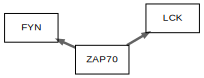

'single_node_structural_graph.gv.svg'

In [10]:
# Input node of interset ... might want the long label - can you do that?

ID_of_node_of_interest = 6

node = C.nodes[ID_of_node_of_interest]

# Make node level effective graph

EG_reversed = EG0p6.reverse()

ego_centric_graph = nx.ego_graph(EG_reversed, 6)

# ego_centric_graph.reverse()

# Draw graph - could try the networkx drawing - but it isn't working for some reason ...
# pos = nx.spring_layout(ego_centric_graph)

pSG = graphviz.Digraph(name='Structural Graph', engine='neato')
pSG.attr('graph', size='10,10', concentrate='false', simplify='false', overlap='false',splines='true',ratio='.7',outputorder="edgesfirst",nodesep='.25',mindist='.20')
pSG.attr('node', pin='true', shape='box', height='0.4', fixedsize='false',margin='.05', color='black', penwidth='1', fontname='Helvetica', fontcolor='black',fontsize='10' ) # style='filled', fillcolor='#515660',)
pSG.attr('edge', arrowhead='normal', arrowsize='.5', penwidth='2.5')

# for nid,SGatt in SG.nodes(data=True):
#     label = SGatt['label']
#     if nid in att:
#         pos = att[nid].get('pos', '')
#         shape = att[nid].get('shape', 'box')
#         fillcolor = colors[att[nid].get('type')]
#         #width = ''att[nid].get('width', '0.7')
#         pSG.node(str(nid), label=label, pos=pos, shape=shape, fillcolor=fillcolor, )

for nid,d in ego_centric_graph.nodes(data=True):
    label = d['label']
#     ntype = att[nid].get('type')
#     pos = att[nid].get('pos', '')
#     shape = att[nid].get('shape')
#     fillcolor = colors[ntype]
    pSG.node(str(nid), label=label, ) #pos=pos, shape=shape, fillcolor=fillcolor,)

max_penwidth = 4
for uid,vid,d in ego_centric_graph.edges(data=True):
    uid = str(uid)
    vid = str(vid)
    weight = '%d' % (d['weight']*100)
    penwidth = '%.2f' % ( d['weight']*max_penwidth )
    if d['weight'] > 0.6:
        if uid == vid:
            color = '#bdbdbd'
            uid = uid + ':w'
            vid = vid + ':c'
        else:
            color = '#636363'
        pSG.edge(uid,vid, weight=weight, penwidth=penwidth, color=color)
    else:
        pSG.edge(uid,vid, style='dashed', color='#A90533')

display(pSG)
pSG.format ='svg'
# Export
pSG.render("single_node_structural_graph", cleanup=True)
pSG.render('single_node_structural_graph.gv')

# nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=False)

# SG = C.structural_graph()
# EG = C.effective_graph(threshold=-1) # now ... what is the difference .... I have my intuition but could be very wrong. And what does -1 mean???
# #
# EG0 = C.effective_graph(threshold=0)
# EG0p2 = C.effective_graph(threshold=.2)
# EG0p4 = C.effective_graph(threshold=.4)
# EG0p6 = C.effective_graph(threshold=.6)
# EG0p8 = C.effective_graph(threshold=.8)